In [2]:
from pacman import runGames,loadAgent
from pacman import Directions
from util import Queue
import textDisplay
import game
import layout
import random
import graphicsDisplay

import numpy as np

In [3]:
class SmartAgent(game.Agent):
    "An agent that does whatever he feels like doing"  
    
    def __init__(self, pesos):
        self.pesos = pesos
        
    def getAction(self, state):
        legal = state.getLegalPacmanActions()
        currentPos=state.getPacmanPosition()
        if Directions.STOP in legal: legal.remove(Directions.STOP)
    
        numCapsulesCurrentState=len(state.getCapsules())
        currentScaredGhosts=self.countScaredGhosts(state)
        currentFoodMatrix = state.getFood()
        
        successors = [(state.generateSuccessor(0, action), action) for action in legal]
        scored = [(self.scoreEvaluation(state,numCapsulesCurrentState,currentScaredGhosts,currentPos,currentFoodMatrix), action) for state, action in successors]
        bestScore = max(scored)[0]
        bestActions = [pair[1] for pair in scored if pair[0] == bestScore]
        
        return random.choice(bestActions)
        
    def getLegalSteps(self, pos, walls, visited):
        
        coluna=pos[0]
        linha=pos[1]
        
        lista=[]

        if(coluna+1 <walls.width):
            if(walls[coluna+1][linha]==False and visited[coluna+1][linha]==0):
                lista.append((coluna+1,linha))
        if(coluna-1 >= 0):
            if(walls[coluna-1][linha]==False and visited[coluna-1][linha]==0):
                lista.append((coluna-1,linha))
        if(linha+1 <walls.height ):
            if(walls[coluna][linha+1]==False and visited[coluna][linha+1]==0):
                lista.append((coluna,linha+1))
        if(linha-1 >= 0):
            if(walls[coluna][linha-1]==False and visited[coluna][linha-1]==0):
                lista.append((coluna,linha-1))
        return lista
    
    def findNearestFood(self, state, posIni, posForbidden):
        walls= state.getWalls()
        foods= state.getFood()
        queue = Queue()
        
        
        visited=np.zeros((walls.width,walls.height))
        visited[posForbidden[0]][posForbidden[1]]=1
        visited[posIni[0]][posIni[1]]=1
                
        matHeight=foods.height
        matWidth=foods.width
        
        queue.push((posIni, 1))
        while(not queue.isEmpty()):
            current=queue.pop()
            pos=current[0]
            stepsUntilNow=current[1]
            
            if(foods[pos[0]][pos[1]]==True):
                return stepsUntilNow
            
            visited[pos[0]][pos[1]]=1
            possibles=self.getLegalSteps(pos,walls, visited) # pos = (x,y), walls = matriz true/falso, visitados  [(2,2),(2,1),(2,3)]
            for possibleMove in possibles:
                queue.push( (possibleMove, stepsUntilNow+1))
        return -1
    
    def bfsDistance(self, state, posIni, posForbidden, endPos):
        walls= state.getWalls()
        queue = Queue()
        
        
        visited=np.zeros((walls.width,walls.height))
        visited[posForbidden[0]][posForbidden[1]] = 1
        visited[posIni[0]][posIni[1]]=1
                
        queue.push((posIni, 1))
        while(not queue.isEmpty()):
            current=queue.pop()
            pos=current[0]
            stepsUntilNow=current[1]
            
            if(pos[0] == endPos[0] and pos[1] == endPos[1]):
                return stepsUntilNow
            
            visited[pos[0]][pos[1]]=1
            possibles = self.getLegalSteps(pos,walls, visited) # pos = (x,y), walls = matriz true/falso, visitados  [(2,2),(2,1),(2,3)]
            for possibleMove in possibles:
                queue.push( (possibleMove, stepsUntilNow+1))
        return -1
    
    def ghostDistances(self, ghostPositions, pacmanPosition, state, currentPacmanPos):
        distancias = []
        
        for i in range(len(ghostPositions)):
            dist = self.bfsDistance(state, pacmanPosition, currentPacmanPos, ghostPositions[i])
            distancias.append(dist)
        
        return distancias
    
    def bonusByGhostDistance(self, peso, distancias, state):
        n_ghosts = len(distancias)
        scared_timer = []

        for i in range(n_ghosts):
            scared_timer.append(state.getGhostStates()[i].scaredTimer)
            
        bonus = 0
        for i in range(n_ghosts):
            if(scared_timer[i] == 0):
                bonus += peso*distancias[i]
        return bonus
    
    def capsuleDistanceBonus(self, peso, capsulePositions, pacmanPosition, state, currentPacmanPos):
        bonus = 0
        for capsule in capsulePositions:
            distancia = self.bfsDistance(state, pacmanPosition, currentPacmanPos, capsule)
            bonus -= peso*distancia
        return bonus
    
    def capsuleComsumptionBonus(self, peso, numCapsulesCurrentState, capsulePositions):
        num_capsulas = numCapsulesCurrentState
        num_capsulas_estado_seguinte = len(capsulePositions)
        
        bonus = (num_capsulas - num_capsulas_estado_seguinte) * peso
        
        return bonus
    
    def countScaredGhosts(self, state):
        total=0
        for ghost in state.getGhostStates():
            if(ghost.scaredTimer !=0):
                total+=1
        return total
    
    def scaredGhostBonus(self, state, peso, distancias):
        n_ghosts = self.countScaredGhosts(state)
        scared_timer = []

        for i in range(n_ghosts):
            scared_timer.append(state.getGhostStates()[i].scaredTimer)
            
        bonus = 0
        for i in range(n_ghosts):
            if(scared_timer[i] != 0):
                bonus -= peso*distancias[i]
        return bonus
    
    def eatScaredGhosts(self, state, peso, currentScaredGhosts):
        scaredGhostsInThisState = self.countScaredGhosts(state)
        difScaredGhosts= currentScaredGhosts - scaredGhostsInThisState
        
        bonus=0
        if(difScaredGhosts > 0):
            bonus= peso * difScaredGhosts
        return bonus
    
    def nearestFoodBonus(self, state, peso, pacmanPosition,currentPacmanPos):
        nearestFoodDistance= self.findNearestFood(state, pacmanPosition,currentPacmanPos)
        bonus = -1* peso * nearestFoodDistance       
        
        return bonus
    
    def eatFoodBonus(self, peso, currentFoodMatrix, foodMatrix):
        diff = currentFoodMatrix.count(True) - foodMatrix.count(True)
        bonus = peso*diff
        
        return bonus
    def scoreEvaluation(self, state, numCapsulesCurrentState, currentScaredGhosts, currentPacmanPos, currentFoodMatrix):
        
#         p1= 1.2
#         p2= 2.1
#         p3= 150
#         p4= 2.5
#         p5 = 10
#         p6 = 2
#         p7 = 50

        p1 = self.pesos[0]
        p2 = self.pesos[1]
        p3 = self.pesos[2]
        p4 = self.pesos[3]
        p5 = self.pesos[4]
        p6 = self.pesos[5]
        p7 = self.pesos[6]
        
        score = state.getScore()
        
        ghostPositions = state.getGhostPositions() 
        pacmanPosition = state.getPacmanPosition()
        capsulePositions = state.getCapsules() 
        foodMatrix = state.getFood()
        
        distancias_fantasmas = self.ghostDistances(ghostPositions, pacmanPosition, state, currentPacmanPos)
        bonus_distancia_fantasmas = self.bonusByGhostDistance(p1, distancias_fantasmas, state)
        
        bonus_distancia_capsula = self.capsuleDistanceBonus(p2, capsulePositions, pacmanPosition, state, currentPacmanPos)
        bonus_consumir_capsula = self.capsuleComsumptionBonus(p3, numCapsulesCurrentState, capsulePositions) 

        bonus_distancia_fantasmas_assustados = self.scaredGhostBonus(state, p4, distancias_fantasmas)
        bonus_comer_fantasmas = self.eatScaredGhosts(state, p5, currentScaredGhosts)
                
        bonus_comida_proxima =  self.nearestFoodBonus(state, p6, pacmanPosition,currentPacmanPos)              
        bonus_comer_comida = self.eatFoodBonus(p7, currentFoodMatrix, foodMatrix)  
                
        formula = score + bonus_distancia_fantasmas + bonus_distancia_capsula + bonus_consumir_capsula + bonus_distancia_fantasmas_assustados + bonus_comer_fantasmas + bonus_comida_proxima + bonus_comer_comida
        return formula

In [4]:
def fitfunction(pesos):
    props={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    props['layout'] = layout.getLayout( 'smallClassic' )
    props['pacman'] = pacman
    props['ghosts'] = []
    props['display'] = textDisplay.NullGraphics()
    #props['display'] = graphicsDisplay.PacmanGraphics(1, frameTime = 0)
    props['numGames'] = 1
    props['record'] = False
    props['catchExceptions'] = True
    props['timeout'] = 1
    
    res = runGames(**props)
    scores = [game.state.getScore() for game in res]
    avgScore = sum(scores) / float(len(scores))
       
    return avgScore

In [5]:
import geneticalgs as ge

model = ge.RealGA(fitness_func = fitfunction, optim='max', selection="rank", mut_prob=0.15, mut_type=1,
                  cross_prob=0.9, cross_type=1, elitism=True, tournament_size=None)

In [6]:
population_size = 100
dimensao = 7 # numero de argumentos da funcao        
interval = (0,1000)

model.init_random_population(population_size, dimensao, interval)

Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.14)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman crashed


Agent 0 ran out of time! (time: 1.01)


In [7]:
max_generation = 30
fitness_progress = model.run(max_generation)

Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman emerges victorious! Score: 989
Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman crashed


Agent 0 ran out of time! (time: 1.00)
Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman emerges victorious! Score: 987
Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman emerges victorious! Score: 984
Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman emerges victorious! Score: 989
Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman emerges victorious! Score: 987
Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman emerges victorious! Score: 982
Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman emerges victorious! Score: 982
Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 986
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman emerges victorious! Score: 982
Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman emerges victorious! Score: 989
Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 976


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 986
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman emerges victorious! Score: 987
Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 986
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman emerges victorious! Score: 989
Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.02)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed


Agent 0 ran out of time! (time: 1.02)


Pacman emerges victorious! Score: 989
Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.01)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 982


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed


Agent 0 ran out of time! (time: 1.00)


Pacman emerges victorious! Score: 989
Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 984
Pacman emerges victorious! Score: 9

Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 987


Agent 0 ran out of time! (time: 1.00)


Pacman crashed
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989
Pacman emerges victorious! Score: 989


In [8]:
new_pesos = model.best_solution[0].tolist()
new_pesos

[975.8658378964558,
 41.035431240762705,
 168.18342895999632,
 698.7424064178213,
 65.0628522660516,
 53.044968587033445,
 1000.0]

In [9]:
maior = 0
for best in model.population:
    if(best.fitness_val > maior):
        maior = best.fitness_val
        melhor_peso = best.chromosome
melhor_peso, maior

(array([975.74099495,  41.58232722, 168.1814725 , 696.50035033,
         65.09411037,  53.54499374, 994.        ]),
 989.0)

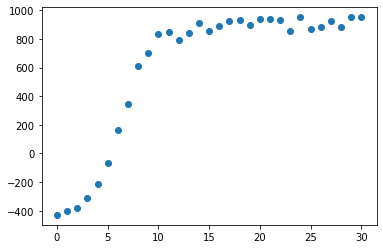

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

x1 = list(range(len(fitness_progress)))

plt.plot(x1, fitness_progress, 'o')

In [ ]:
interval = (0,1000)
model.init_population()

In [1]:
props={}
pacman = SmartAgent(melhor_peso)
ghostType = loadAgent('RandomGhost', True)
textDisplay.SLEEP_TIME = 0
props['layout'] = layout.getLayout( 'smallClassic' )
props['pacman'] = pacman
#props['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
props['ghosts'] = []
props['display'] = graphicsDisplay.PacmanGraphics(1, frameTime = 0)
#props['display'] = textDisplay.NullGraphics()
props['numGames'] = 1
props['record'] = False
props['catchExceptions'] = False
props['timeout'] = 1
    
games = runGames(**props)
scores = [game.state.getScore() for game in games]
avg = sum(scores) / float(len(scores))
int(avg)

NameError: name 'SmartAgent' is not defined